In [134]:
import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
import re
from geopy.distance import vincenty
import matplotlib.dates as mdts
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from time import time
from tsfresh import extract_relevant_features, extract_features

In [10]:
accdnt_windows = pd.read_csv('../data/PeMS/Incidents/work_folder/year_accdnt_wndw.csv', parse_dates=['Timestamp'])

In [11]:
accdnt_windows['y'] = 1

In [12]:
accdnt_free_windows = pd.read_csv('../data/PeMS/Incidents/work_folder/year_accdnt_free_wndw.csv', parse_dates=['Timestamp'])

In [13]:
accdnt_free_windows['y'] = 0

In [14]:
def plot_window(data, chrct = 'Total Flow'):
    
#     cols = [col for col in data.columns if chrct in col]
    cols = [col for col in data.index if chrct in col]
    data[cols].plot()
    plt.grid()
    plt.show()

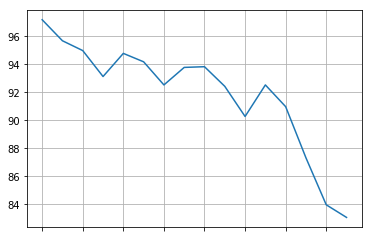

In [15]:
plot_window(accdnt_free_windows.iloc[86])

In [6]:
common_cols = ['Timestamp', 'Latitude', 'Longitude', 'Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15', 'y']

In [9]:
dataset = pd.concat((accdnt_windows[common_cols], accdnt_free_windows[common_cols]), axis=0)

In [10]:
dataset['Hour'] = dataset.Timestamp.dt.hour

In [11]:
dataset = dataset.drop(index=dataset[(dataset['Hour']<6) | (dataset['Hour']>21)].index).reset_index(drop=True)

In [12]:
dataset = pd.get_dummies(dataset, columns=['Hour'], prefix='hour_').drop(columns=['Timestamp'])

In [13]:
dataset = dataset.loc[np.random.choice(dataset.shape[0], dataset.shape[0], replace=False)]

In [15]:
dataset.reset_index(drop=True, inplace=True)

In [26]:
dataset.to_csv('../data/PeMS/Incidents/work_folder/windows.csv', index=False)

In [17]:
dataset= pd.read_csv('../data/PeMS/Incidents/work_folder/windows.csv')

In [32]:
def feature_extraction(dataset):
    cols = [col for col in dataset.columns if 'Avg' in col or 'Total' in col]
    dataset = dataset[cols]
    t_labels = np.arange(len(cols)/3, dtype=int)
    t_labels = np.concatenate((t_labels,t_labels,t_labels))
    aux_labels = pd.DataFrame({'val_name': cols, 't': t_labels})
    long = dataset.reset_index().melt(id_vars=['index'], var_name='series_param', value_name='value')
    long = long.merge(aux_labels, how='left', left_on='series_param', right_on='val_name').drop('val_name', axis=1)
    long['series_param'] = long['series_param'].apply(lambda row: row.split('_')[0])
    long = long.rename(columns={'index': 'ID'})[['ID', 't', 'series_param', 'value']]
    extracted = extract_features(long, column_id='ID', column_sort='t', column_kind='series_param', column_value='value', n_jobs=4)
    # try imputation
    extracted.dropna(axis=1, how='any', inplace=True)
    return extracted

In [33]:
def batch_extraction(dataset, b_size):
    m=dataset.shape[0]
    result=pd.DataFrame()
    for i in range(0, m, b_size):
        crnt_ftrs = feature_extraction(dataset.loc[i:i+b_size-1])
#         result = pd.concat((result, crnt_ftrs))
        crnt_ftrs.to_csv('../data/PeMS/Incidents/work_folder/extracted/extracted_{0:d}.csv'.format(i), index=False)
    print('EGOR virubajjj!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')


In [34]:
batch_extraction(dataset, 1000)

Feature Extraction: 100%|██████████| 20/20 [01:20<00:00,  4.02s/it]


EGOR virubajjj!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [25]:
non_series_cols = [col for col in dataset.columns if 'Avg' not in col and 'Total' not in col]

In [27]:
data_1 = pd.read_csv('../data/PeMS/Incidents/work_folder/extracted/extracted_0.csv')

In [81]:
data_1 = pd.concat((data_1, dataset.loc[:999][non_series_cols]), axis=1)

In [41]:
data_1 = data_1.replace([np.inf, -np.inf], np.NaN)

data_1.dropna(axis=1, inplace=True)

In [129]:
tr_X, te_X, tr_y, te_y = train_test_split(test.drop(columns=['y']), test['y'], stratify=test.y, test_size=.2)

In [130]:
logreg = LogisticRegression()
logreg.fit(tr_X, tr_y)
print('acc =', logreg.score(te_X, te_y))
predict = logreg.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict))

acc = 0.6853333333333333
f1 = 0.5914460285132384
CM = [[2917  579]
 [1427 1452]]


In [131]:
forest = RandomForestClassifier(random_state=14)
forest.fit(tr_X, tr_y)
print('acc =', forest.score(te_X, te_y))
predict = forest.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict, labels=[0,1]))

acc = 0.6955294117647058
f1 = 0.6200822078684675
CM = [[2850  646]
 [1295 1584]]


In [139]:
proba = forest.predict_proba(te_X)

In [153]:
fpr, tpr, _ = roc_curve(te_y, proba[:,1])

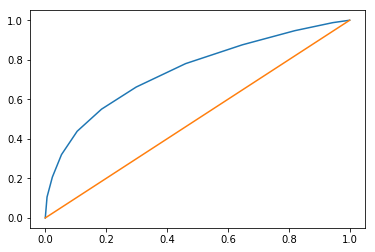

In [155]:
plt.plot(fpr, tpr)
plt.plot([0, 1],[0,1])
plt.show()

In [122]:
def batch_concatenation(dataset, b_size):
    m=dataset.shape[0]
    result = pd.DataFrame()
    for i in range(0, m, b_size):
        crnt_ftrs = pd.read_csv('../data/PeMS/Incidents/work_folder/extracted/extracted_{0:d}.csv'.format(i))
#         print(crnt_ftrs.shape)
#         crnt_ftrs = pd.concat((crnt_ftrs, dataset.loc[i:i+b_size-1][non_series_cols]), axis=1)
        crnt_ftrs = crnt_ftrs.replace([np.inf, -np.inf], np.NaN)
        crnt_ftrs.dropna(axis=1, inplace=True)
        result = pd.concat((result, crnt_ftrs), axis=0)
#         if i>1000:
#             break
    return result.reset_index(drop=False)

In [123]:
test = batch_concatenation(dataset,1000)

In [124]:
test.dropna(axis=1, inplace=True)

In [125]:
test = pd.concat((test, dataset[non_series_cols]), axis=1)

In [227]:
tr_X, te_X, tr_y, te_y = train_test_split(dataset.drop(columns=['y']), dataset['y'], stratify=dataset.y)

In [228]:
scaler = StandardScaler()

In [229]:
tr_X = scaler.fit_transform(tr_X)

In [230]:
te_X = scaler.transform(te_X)

In [231]:
logreg = LogisticRegression()
logreg.fit(tr_X, tr_y)
print('acc =', logreg.score(te_X, te_y))
predict = logreg.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict))

acc = 0.6851549755301795
f1 = 0.5977232643899312
CM = [[3596  774]
 [1735 1864]]


In [262]:
forest = RandomForestClassifier(random_state=14)
forest.fit(tr_X, tr_y)
print('acc =', forest.score(te_X, te_y))
predict = forest.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict, labels=[0,1]))

acc = 0.7017191617517882
f1 = 0.6341388333076805
CM = [[3532  838]
 [1539 2060]]


In [263]:
grid_params = {'n_estimators': [10, 100, 200],
               'max_depth' : [2, 3, 5],  
               'min_samples_leaf': [2, 5, 10]
}
grd_search = GridSearchCV(forest, grid_params,
                          scoring={'f1_score' : make_scorer(f1_score)},
                          refit='f1_score',
                          cv=5, return_train_score=True, n_jobs=-1, verbose=2)

In [264]:
grd_search.fit(tr_X, tr_y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.1s
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.0s
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.0s
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.1s
[CV] max_depth=2, min_samples_leaf=2, n_estimators=100 ...............
[CV] max_depth=2, min_samples_leaf=2, n_estimators=100 ...............
[CV] max_depth=2, min_samples_leaf=2, n_estimators=100 ...............
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   0.4s
[CV] max_depth=

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.3s


[CV]  max_depth=2, min_samples_leaf=5, n_estimators=200, total=   6.7s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.6s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.7s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.9s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_leaf=5, n_estimators=200, total=   7.0s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.1s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.3s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[

[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=14, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 200], 'max_depth': [2, 3, 5], 'min_samples_leaf': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit='f1_score', return_train_score=True,
       scoring={'f1_score': make_scorer(f1_score)}, verbose=2)

In [265]:
grd_search.best_score_

0.5738945649022463

In [268]:
grd_search.score(te_X, te_y)

0.5858153694257034